<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/Model_interpretations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Plot function

In [37]:
def avg_prob(unique_temperatures, predictions, temperatures):
  # Initialize an array to store average prediction probabilities for each unique temperature
  average_probabilities = np.zeros_like(unique_temperatures, dtype=float)

  # Calculate average prediction probability for each unique temperature
  for i, temp in enumerate(unique_temperatures):
      # Find indices corresponding to the current unique temperature
      temp_indices = np.where(temperatures == temp)
      # Extract prediction probabilities for these indices
      temp_predictions = predictions[temp_indices]
      # Calculate average prediction probability
      average_prob = np.mean(temp_predictions)
      # Store the average probability
      average_probabilities[i] = average_prob
  return average_probabilities

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predictions' is the array containing prediction probabilities
# and 'temperatures' is the array containing corresponding temperatures
def plot_proba(temperatures, predictions1, predictions2, label1 = 'Ordered state', label2 = 'Disordered state', titl = 'Average Prediction Probability per Temperature'):
# Calculate unique temperature values and their corresponding indices
  unique_temperatures, indices = np.unique(temperatures, return_inverse=True)
  avg_proba1 = avg_prob(unique_temperatures, predictions1, temperatures)
  avg_proba2 = avg_prob(unique_temperatures, predictions2, temperatures)

  # Plot the average prediction probabilities against temperature
  plt.figure(figsize=(8, 6))
  plt.plot(unique_temperatures, avg_proba1, marker='o', linestyle='-', label = label1)
  plt.plot(unique_temperatures, avg_proba2, marker='o', linestyle='-', label = label2)
  plt.legend()
  plt.xlabel('Temperature')
  plt.ylabel('Average Prediction Probability')
  plt.title(titl)

  plt.grid(True)
  plt.show()


### Model

#### Accuracy, train and test functions

In [3]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [39]:
import numpy as np

def calculate_accuracy_np(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).astype(float)

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape

    # Calculate the number of correct predictions
    correct = np.sum(predicted == labels).astype(float) / 2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.shape[0]

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [4]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  model.train()
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [5]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [6]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [7]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [9]:
def file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [10]:
def full_file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    # Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [11]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


In [12]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader named original_dataloader
# Define a new DataLoader class to subset the original DataLoader
class SubsetDataLoader(DataLoader):
    def __init__(self, dataloader, num_batches):
        super(SubsetDataLoader, self).__init__(dataloader.dataset, batch_size=dataloader.batch_size)
        self.dataloader = dataloader
        self.num_batches = num_batches
        self.current_batch = 0

    def __iter__(self):
        self.current_batch = 0
        self.dataloader_iter = iter(self.dataloader)
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        self.current_batch += 1
        return next(self.dataloader_iter)

Train and test data:

In [13]:
# Anti-ferromagnetic dataset: train and test

X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data_anti.npz')

In [14]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-11-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-11-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Class: [0. 1.]
Temperature: 3.5


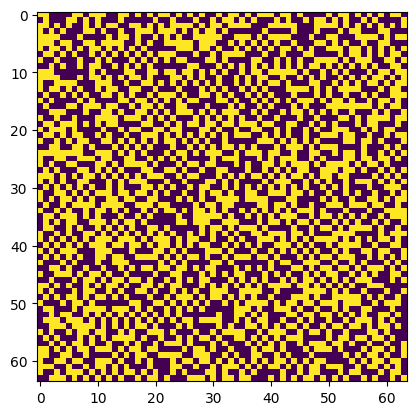

In [ ]:
plt.imshow(X_train_anti[30])
print("Class:", y_train_anti[30])
print("Temperature:", Y_train_anti[30])

#### Fully Connected Neural Network

In [15]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [16]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# # Dataset 1, NN -> antiFe, NNN -> Fe
# X_anti, y_anti, Y_anti = full_file_loader('data_anti.npz')
# dataset_anti = IsingDataset(X_anti, y_anti)
# batch_size = 128
# dataloader_anti = DataLoader(dataset = dataset_anti, batch_size = batch_size, shuffle = False)

In [17]:
train(FCNN, 10, criterion_FCNN, optimizer_FCNN, train_dataloader_anti)

Loss: 0.7050490379333496 ,Train accuracy: 0.53515625
Loss: 0.6916804313659668 ,Train accuracy: 0.5546875
Loss: 0.7078025341033936 ,Train accuracy: 0.71875
Loss: 0.6962197422981262 ,Train accuracy: 0.5
Loss: 0.6878236532211304 ,Train accuracy: 0.39453125
Loss: 0.6792199611663818 ,Train accuracy: 0.70703125
Loss: 0.6786312460899353 ,Train accuracy: 0.484375
Loss: 0.6872419118881226 ,Train accuracy: 0.5234375
Loss: 0.6613230109214783 ,Train accuracy: 0.5625
Loss: 0.60711669921875 ,Train accuracy: 0.859375
Loss: 0.6201596260070801 ,Train accuracy: 0.84375
Loss: 0.6506072282791138 ,Train accuracy: 0.80078125
Loss: 0.6531431674957275 ,Train accuracy: 0.75390625
Loss: 0.6292590498924255 ,Train accuracy: 0.5390625
Loss: 0.6082223653793335 ,Train accuracy: 0.765625
Loss: 0.6051375269889832 ,Train accuracy: 0.84375
Loss: 0.6030099391937256 ,Train accuracy: 0.82421875
Loss: 0.5492612719535828 ,Train accuracy: 0.8515625
Loss: 0.5530610680580139 ,Train accuracy: 0.81640625
Loss: 0.5089530348777771 

In [ ]:
test(FCNN, criterion_FCNN, test_dataloader_anti)

0 :: Loss: 0.1944330930709839 ,Test accuracy: 0.9296875
1 :: Loss: 0.3490474820137024 ,Test accuracy: 0.87890625
2 :: Loss: 0.2394697368144989 ,Test accuracy: 0.93359375
3 :: Loss: 0.3447885811328888 ,Test accuracy: 0.90625
4 :: Loss: 0.3742731213569641 ,Test accuracy: 0.890625
5 :: Loss: 0.1726294755935669 ,Test accuracy: 0.9375
6 :: Loss: 0.37815940380096436 ,Test accuracy: 0.89453125
7 :: Loss: 0.35600364208221436 ,Test accuracy: 0.890625
8 :: Loss: 0.22086834907531738 ,Test accuracy: 0.90625
9 :: Loss: 0.38123810291290283 ,Test accuracy: 0.875
10 :: Loss: 0.22011587023735046 ,Test accuracy: 0.9375
11 :: Loss: 0.39048415422439575 ,Test accuracy: 0.8671875
12 :: Loss: 0.5222269296646118 ,Test accuracy: 0.8671875
13 :: Loss: 0.22922751307487488 ,Test accuracy: 0.91015625
14 :: Loss: 0.31962859630584717 ,Test accuracy: 0.875
15 :: Loss: 0.3035730719566345 ,Test accuracy: 0.9296875
16 :: Loss: 0.4342727065086365 ,Test accuracy: 0.86328125
17 :: Loss: 0.3147673010826111 ,Test accuracy: 0

#### CNN:

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [19]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['binary_accuracy'])
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [20]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader_anti)

Loss: 0.7087987661361694 ,Train accuracy: 0.484375
Loss: 0.055428583174943924 ,Train accuracy: 0.9765625
Loss: 0.07458347827196121 ,Train accuracy: 0.984375
Loss: 0.027027465403079987 ,Train accuracy: 0.9921875
Loss: 0.027257246896624565 ,Train accuracy: 0.9921875
Loss: 0.03336881101131439 ,Train accuracy: 0.9921875
Loss: 0.0351969376206398 ,Train accuracy: 0.9921875
Loss: 0.01388805452734232 ,Train accuracy: 1.0
Loss: 0.026753481477499008 ,Train accuracy: 0.9921875
Loss: 0.026054104790091515 ,Train accuracy: 0.9921875
Loss: 0.050995197147130966 ,Train accuracy: 0.984375
Loss: 0.06618546694517136 ,Train accuracy: 0.9765625
Loss: 0.05158640444278717 ,Train accuracy: 0.984375
Loss: 0.021467432379722595 ,Train accuracy: 0.9921875
Loss: 0.03121979534626007 ,Train accuracy: 0.9921875
Loss: 0.024848362430930138 ,Train accuracy: 0.984375
Loss: 0.016011517494916916 ,Train accuracy: 1.0
Loss: 0.017181983217597008 ,Train accuracy: 1.0
Loss: 0.02543998509645462 ,Train accuracy: 0.984375
Loss: 0.0

In [ ]:
test(CNN, criterion_CNN, test_dataloader_anti)

0 :: Loss: 0.007358435541391373 ,Test accuracy: 0.9921875
1 :: Loss: 0.051551010459661484 ,Test accuracy: 0.9921875
2 :: Loss: 0.06564091145992279 ,Test accuracy: 0.9921875
3 :: Loss: 0.0015260251238942146 ,Test accuracy: 1.0
4 :: Loss: 0.0007138767396099865 ,Test accuracy: 1.0
5 :: Loss: 0.015148177742958069 ,Test accuracy: 0.9921875
6 :: Loss: 0.0013670118059962988 ,Test accuracy: 1.0
7 :: Loss: 0.01786477118730545 ,Test accuracy: 0.9921875
8 :: Loss: 0.01667141728103161 ,Test accuracy: 0.9921875
9 :: Loss: 0.016010018065571785 ,Test accuracy: 0.9921875
10 :: Loss: 0.006527744233608246 ,Test accuracy: 0.9921875
11 :: Loss: 0.0654040277004242 ,Test accuracy: 0.984375
12 :: Loss: 0.10150868445634842 ,Test accuracy: 0.9765625
13 :: Loss: 0.07882954180240631 ,Test accuracy: 0.9921875
14 :: Loss: 0.04882243275642395 ,Test accuracy: 0.984375
15 :: Loss: 0.000675296294502914 ,Test accuracy: 1.0
16 :: Loss: 0.024225745350122452 ,Test accuracy: 0.9921875
17 :: Loss: 0.03219882398843765 ,Test 

In [21]:
torch.save(CNN.state_dict(), 'CNN_anti.pth')

### Feature Maps

In [ ]:
# Example Usage:
# model = ConvNet(40, 40)
def plot_feature_map(model, x, y, print_data = False):
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = model(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  print(data)
  plt.imshow(data)
  plt.colorbar()
  plt.title(f'Temperature={y}')
  plt.show()

Text(0.5, 1.0, 'Temperature=1.5')

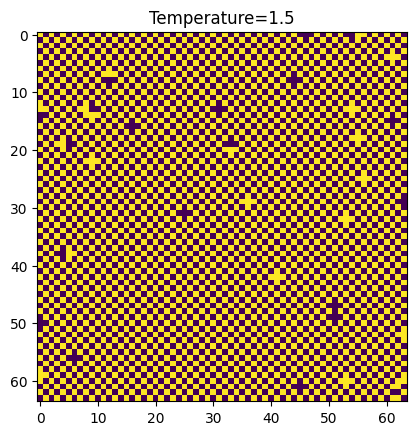

In [ ]:
plt.imshow(X_train_anti[0])
plt.title(f"Temperature={Y_train_anti[0]}")

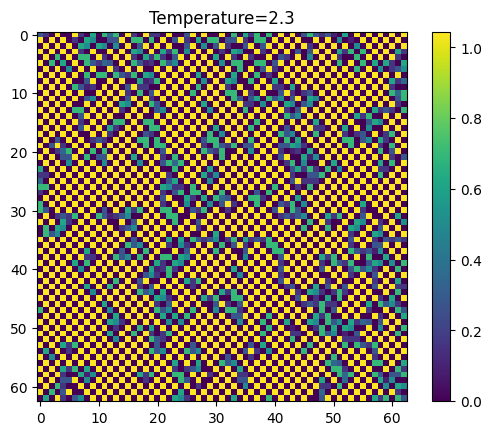

In [ ]:
plot_feature_map(CNN, X_train_anti[2000], Y_train_anti[2000])

### Testing on NNN data

###### Loading the datasets and the trained model

In [ ]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [ ]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [ ]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X3, y3, Y3 = full_file_loader('data_64NNN_anti_noshuffle_reduced.npz', 8.5)

In [ ]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset3 = IsingDataset(X3, y3)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader3 = DataLoader(dataset = dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
FCNN.load_state_dict(torch.load('NeuralNetwork_weights_anti64.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

###### CNN

In [ ]:
dataset3.__len__()

2200

In [ ]:
test(CNN, criterion_CNN, dataloader3)

0 :: Loss: 0.29558154940605164 ,Test accuracy: 0.8046875
1 :: Loss: 0.36221787333488464 ,Test accuracy: 0.7734375
2 :: Loss: 0.5728088617324829 ,Test accuracy: 0.640625
3 :: Loss: 1.1437149047851562 ,Test accuracy: 0.453125
4 :: Loss: 2.1804964542388916 ,Test accuracy: 0.2890625
5 :: Loss: 6.9383697509765625 ,Test accuracy: 0.0390625
6 :: Loss: 14.726797103881836 ,Test accuracy: 0.03125
7 :: Loss: 23.744009017944336 ,Test accuracy: 0.1875
8 :: Loss: 3.6306802940089256e-05 ,Test accuracy: 1.0
9 :: Loss: 4.2523242882452905e-06 ,Test accuracy: 1.0
10 :: Loss: 1.218090687871154e-06 ,Test accuracy: 1.0
11 :: Loss: 6.011301593389362e-06 ,Test accuracy: 1.0
12 :: Loss: 2.9521771693907795e-07 ,Test accuracy: 1.0
13 :: Loss: 7.926639227662235e-06 ,Test accuracy: 1.0
14 :: Loss: 1.3338017197384033e-06 ,Test accuracy: 1.0
15 :: Loss: 9.740622317622183e-07 ,Test accuracy: 1.0
16 :: Loss: 8.488352705171565e-07 ,Test accuracy: 1.0
17 :: Loss: 1.0601809360966108e-11 ,Test accuracy: 1.0


<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader3, CNN)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


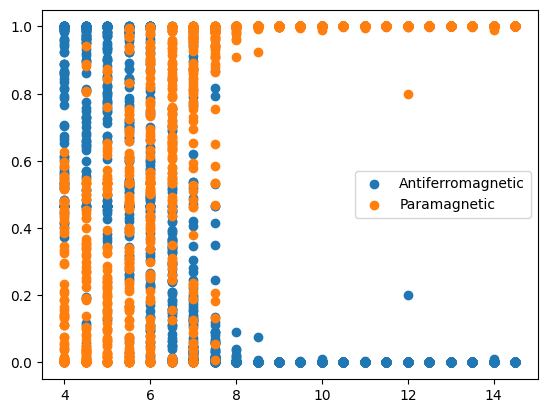

In [ ]:
plt.scatter(Y3, pred_class1, label='Antiferromagnetic')
plt.scatter(Y3, pred_class2, label='Paramagnetic')
plt.legend()

###### FCNN

In [ ]:
dataset3.__len__()

2200

In [ ]:
test(FCNN, criterion_FCNN, dataloader3)

0 :: Loss: 1.7272565364837646 ,Test accuracy: 0.55859375
1 :: Loss: 1.6813437938690186 ,Test accuracy: 0.4140625
2 :: Loss: 2.280813455581665 ,Test accuracy: 0.37109375
3 :: Loss: 1.712501883506775 ,Test accuracy: 0.43359375
4 :: Loss: 1.4424455165863037 ,Test accuracy: 0.54296875
5 :: Loss: 1.9115322828292847 ,Test accuracy: 0.42578125
6 :: Loss: 2.667715072631836 ,Test accuracy: 0.328125
7 :: Loss: 2.931903600692749 ,Test accuracy: 0.3515625
8 :: Loss: 0.6326177716255188 ,Test accuracy: 0.7890625
9 :: Loss: 0.7200087308883667 ,Test accuracy: 0.8046875
10 :: Loss: 0.4871750771999359 ,Test accuracy: 0.796875
11 :: Loss: 0.8627126216888428 ,Test accuracy: 0.8125
12 :: Loss: 0.6343590021133423 ,Test accuracy: 0.75390625
13 :: Loss: 0.6946726441383362 ,Test accuracy: 0.76171875
14 :: Loss: 0.730778694152832 ,Test accuracy: 0.7578125
15 :: Loss: 0.8178161382675171 ,Test accuracy: 0.74609375
16 :: Loss: 0.6539164185523987 ,Test accuracy: 0.78125
17 :: Loss: 0.7420551180839539 ,Test accuracy

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader3, FCNN)

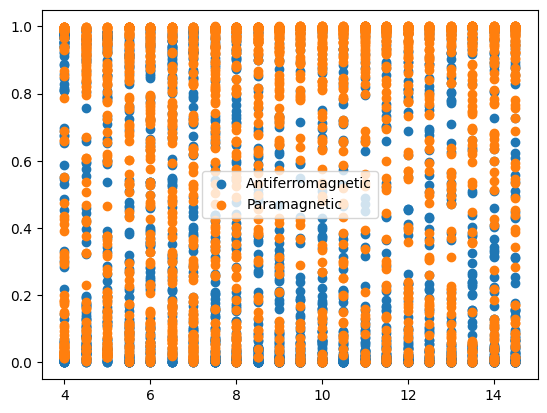

In [ ]:
plt.scatter(Y3, pred_class1, label='Antiferromagnetic')
plt.scatter(Y3, pred_class2, label='Paramagnetic')
plt.legend()

#### Data Visualization

In [ ]:
for idx, i in enumerate(Y2):
  if i>3:
    print(idx)
    print(i)
    break

3
3.1


Text(0.5, 1.0, 'Temperature = 8.5, Class = [1. 0.]')

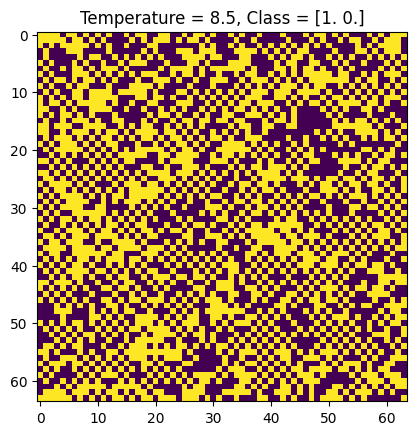

In [ ]:
plt.imshow(X3[900])
plt.title(f"Temperature = {Y3[900]}, Class = {y3[900]}")

Text(0.5, 1.0, 'Temperature = 4.0')

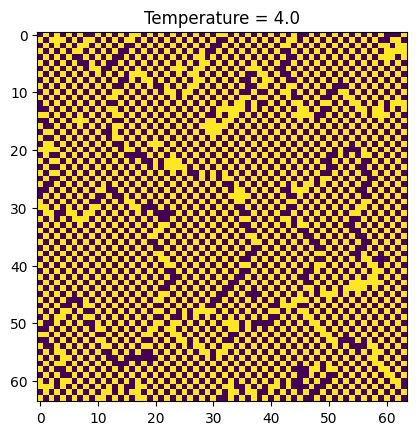

In [ ]:
plt.imshow(X3[0])
plt.title(f"Temperature = {Y3[0]}")

In [ ]:
# Class 1 -> Paramagnetic, Class 2 -> Antiferromagnetic ([0. 1.] -> AFM)
## Samples getting predicted incorrectly:
for index in range(dataset3.__len__()):
    if(np.round(pred_class1[index]) != y3[index][0]):
        print(f"\033[1mIndex: {index}\033[0m")
        print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
        print(f"EXPECTED: {y3[index]}")

---
A few datapoints from the above printed data: <br>
<small><b>Index: 1</b> <br>
PREDICTED: 0.5311572551727295, 0.4595322012901306 <br>
EXPECTED: [0. 1.]<br>
<b>Index: 12</b><br>
PREDICTED: 0.723466694355011, 0.26100102066993713<br>
EXPECTED: [0. 1.]<br>
<b>Index: 13 </b><br>
PREDICTED: 0.8141891360282898, 0.19164887070655823<br>
EXPECTED: [0. 1.]<br></small>

PREDICTED: 0.02166641131043434, 0.971859335899353
EXPECTED: [0. 1.]


Text(0.5, 1.0, 'Temperature = 4.0')

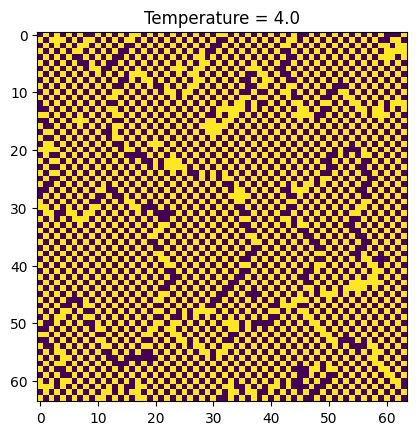

In [ ]:
index = 0
print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
print(f"EXPECTED: {y3[index]}")
plt.imshow(X3[index])
plt.title(f"Temperature = {Y3[index]}")

PREDICTED: 0.8141891360282898, 0.19164887070655823
EXPECTED: [0. 1.]


Text(0.5, 1.0, 'Temperature = 4.0')

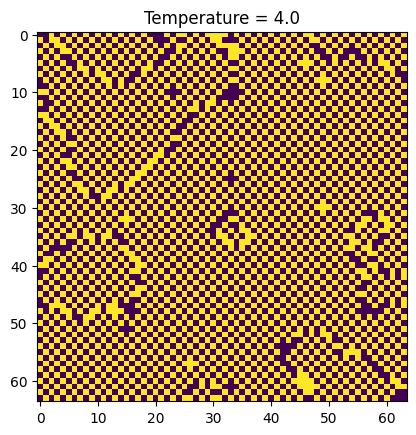

In [ ]:
index = 13
print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
print(f"EXPECTED: {y3[index]}")
plt.imshow(X3[index])
plt.title(f"Temperature = {Y3[index]}")

#### To check if the model correctly predicts a perfectly anti-ferromagnetic lattice

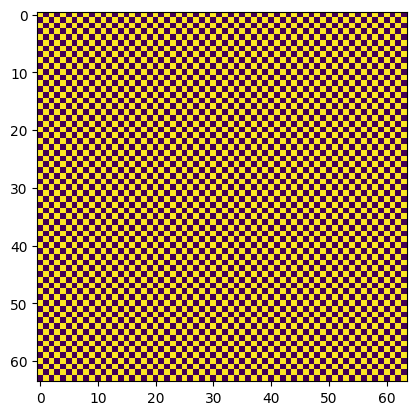

In [ ]:
test_input1 = np.ones((1, 64, 64))  # Add an additional dimension for batch size of 1
test_input1[:, 1::2, ::2] = -1
test_input1[:, ::2, 1::2] = -1

plt.imshow(test_input1.squeeze())  # Squeeze the batch dimension for visualization
plt.show()

CNN

In [ ]:
# Resolve the error
pred_c1, pred_c2 = get_predictions_np(test_input1, CNN, device)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


In [ ]:
print(f"{pred_c1}, {pred_c2}")

[1.], [1.1239331e-12]


FCNN

In [ ]:
# Resolve the error
pred_c1, pred_c2 = get_predictions_np(test_input1, FCNN, device)

In [ ]:
print(f"{pred_c1}, {pred_c2}")

[0.9846149], [0.01495955]


---
---


#### Train a CNN on NNN data and test on NN data


In [ ]:
# Anti-ferromagnetic dataset: train and test

X3_train, X3_test, y3_train, y3_test, Y3_train, Y3_test = file_loader('data_64NNN_anti_noshuffle_reduced.npz', 8.5)

In [ ]:
training_dataset3 = IsingDataset(X3_train, y3_train)
testing_dataset3 = IsingDataset(X3_test, y3_test)
batch_size = 128
train_dataloader3 = DataLoader(dataset = training_dataset3, batch_size = batch_size, shuffle = False)
test_dataloader3 = DataLoader(dataset = testing_dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
CNN_NNN = ConvNet(Nx, Ny).to(device)
criterion_CNN_NNN = nn.BCELoss()
optimizer_CNN_NNN = optim.Adam(CNN_NNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [ ]:
train(CNN_NNN, 10, criterion_CNN_NNN, optimizer_CNN_NNN, train_dataloader3)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


Loss: 0.6628439426422119 ,Train accuracy: 0.6796875
Loss: 3.975001107621185e-15 ,Train accuracy: 1.0
Loss: 5.2653908922460834e-18 ,Train accuracy: 1.0
Loss: 1.7489364241339382e-17 ,Train accuracy: 1.0
Loss: 4.7070643274158585e-17 ,Train accuracy: 1.0
Loss: 6.212670449240576e-21 ,Train accuracy: 1.0
Loss: 3.736870004358564e-21 ,Train accuracy: 1.0
Loss: 1.2790432216038747e-18 ,Train accuracy: 1.0
Loss: 2.983737146212863e-19 ,Train accuracy: 1.0
Loss: 1.7660018880898462e-16 ,Train accuracy: 1.0


In [ ]:
test(CNN_NNN, criterion_CNN_NNN, test_dataloader3)

0 :: Loss: 7.121848243021054e-23 ,Test accuracy: 1.0
1 :: Loss: 1.526085232084884e-16 ,Test accuracy: 1.0
2 :: Loss: 1.2620517153040522e-13 ,Test accuracy: 1.0


<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


In [ ]:
# Other way round it is not working
test(CNN_NNN, criterion_CNN_NNN, test_dataloader_anti)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 37.17237854003906 ,Test accuracy: 0.578125
1 :: Loss: 39.872161865234375 ,Test accuracy: 0.546875
2 :: Loss: 44.020572662353516 ,Test accuracy: 0.5
3 :: Loss: 44.79127883911133 ,Test accuracy: 0.5
4 :: Loss: 42.041595458984375 ,Test accuracy: 0.5234375
5 :: Loss: 41.87174987792969 ,Test accuracy: 0.53125
6 :: Loss: 41.75581741333008 ,Test accuracy: 0.53125
7 :: Loss: 47.38581848144531 ,Test accuracy: 0.4609375
8 :: Loss: 50.064476013183594 ,Test accuracy: 0.4375
9 :: Loss: 46.29566192626953 ,Test accuracy: 0.4765625
10 :: Loss: 50.66930389404297 ,Test accuracy: 0.421875
11 :: Loss: 43.111297607421875 ,Test accuracy: 0.5078125
12 :: Loss: 42.2779655456543 ,Test accuracy: 0.5234375
13 :: Loss: 43.29917907714844 ,Test accuracy: 0.515625
14 :: Loss: 39.417694091796875 ,Test accuracy: 0.5546875
15 :: Loss: 42.808807373046875 ,Test accuracy: 0.515625
16 :: Loss: 42.911128997802734 ,Test accuracy: 0.515625
17 :: Loss: 36.57139205932617 ,Test accuracy: 0.5859375
18 :: Loss: 39.55314

### Test on R = -3 data

###### Loading the datasets and the trained model

In [ ]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [ ]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [ ]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X4, y4, Y4 = full_file_loader('data_64NNN_anti_noshuffle_R3.npz', 14)

In [ ]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset4 = IsingDataset(X4, y4)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader4 = DataLoader(dataset = dataset4, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [ ]:
dataset4.__len__()

3800

In [ ]:
test(CNN, criterion_CNN, dataloader4)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 0.25550365447998047 ,Test accuracy: 0.765625
1 :: Loss: 0.48347344994544983 ,Test accuracy: 0.46875
2 :: Loss: 0.454931378364563 ,Test accuracy: 0.609375
3 :: Loss: 0.4612312316894531 ,Test accuracy: 0.5625
4 :: Loss: 0.397580623626709 ,Test accuracy: 0.640625
5 :: Loss: 0.509907603263855 ,Test accuracy: 0.484375
6 :: Loss: 0.5240910053253174 ,Test accuracy: 0.484375
7 :: Loss: 0.5279350280761719 ,Test accuracy: 0.46875
8 :: Loss: 0.5832240581512451 ,Test accuracy: 0.453125
9 :: Loss: 0.6077211499214172 ,Test accuracy: 0.3984375
10 :: Loss: 0.8463791608810425 ,Test accuracy: 0.40625
11 :: Loss: 1.3740463256835938 ,Test accuracy: 0.2890625
12 :: Loss: 2.538667917251587 ,Test accuracy: 0.21875
13 :: Loss: 6.368062973022461 ,Test accuracy: 0.09375
14 :: Loss: 11.113304138183594 ,Test accuracy: 0.0078125
15 :: Loss: 26.210063934326172 ,Test accuracy: 0.0
16 :: Loss: 41.5428352355957 ,Test accuracy: 0.0
17 :: Loss: 51.615028381347656 ,Test accuracy: 0.0
18 :: Loss: 61.18507385253

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader4, CNN)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


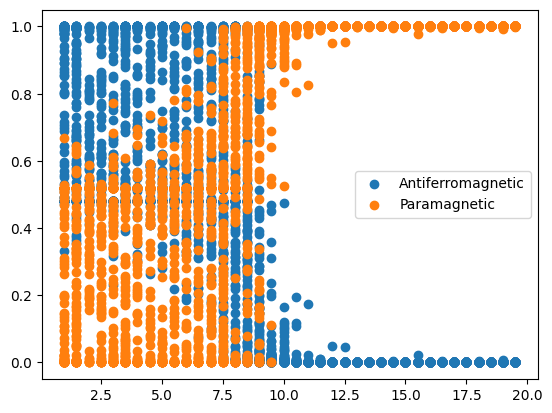

In [ ]:
plt.scatter(Y4, pred_class1, label='Antiferromagnetic')
plt.scatter(Y4, pred_class2, label='Paramagnetic')
plt.legend()

### Test on R = -1 data

###### Loading the datasets and the trained model

In [87]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X5, y5, Y5 = full_file_loader('data_64NNN_anti_noshuffle_R1.npz', 5.5)

In [88]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset5 = IsingDataset(X5, y5)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader5 = DataLoader(dataset = dataset5, batch_size = batch_size, shuffle = False)

<ipython-input-11-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-11-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [89]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [90]:
dataset5.__len__()

3800

In [91]:
test(CNN, criterion_CNN, dataloader5)

0 :: Loss: 0.29001280665397644 ,Test accuracy: 0.8359375
1 :: Loss: 0.26697003841400146 ,Test accuracy: 0.828125
2 :: Loss: 0.32193854451179504 ,Test accuracy: 0.703125
3 :: Loss: 0.37391993403434753 ,Test accuracy: 0.7734375
4 :: Loss: 0.4557061493396759 ,Test accuracy: 0.609375
5 :: Loss: 1.0017261505126953 ,Test accuracy: 0.359375
6 :: Loss: 4.483988285064697 ,Test accuracy: 0.0546875
7 :: Loss: 11.421611785888672 ,Test accuracy: 0.1953125
8 :: Loss: 0.0005367801059037447 ,Test accuracy: 1.0
9 :: Loss: 0.010416545905172825 ,Test accuracy: 1.0
10 :: Loss: 0.005139004439115524 ,Test accuracy: 1.0
11 :: Loss: 0.005119109991937876 ,Test accuracy: 1.0
12 :: Loss: 0.005076166708022356 ,Test accuracy: 1.0
13 :: Loss: 7.198414095910266e-05 ,Test accuracy: 1.0
14 :: Loss: 1.9655184587463737e-05 ,Test accuracy: 1.0
15 :: Loss: 2.155689253413584e-05 ,Test accuracy: 1.0
16 :: Loss: 3.1500121622229926e-06 ,Test accuracy: 1.0
17 :: Loss: 7.430227469740203e-06 ,Test accuracy: 1.0
18 :: Loss: 1.146

In [94]:
pred_class1, pred_class2 = get_predictions(dataloader5, CNN)

Text(0.5, 1.0, 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

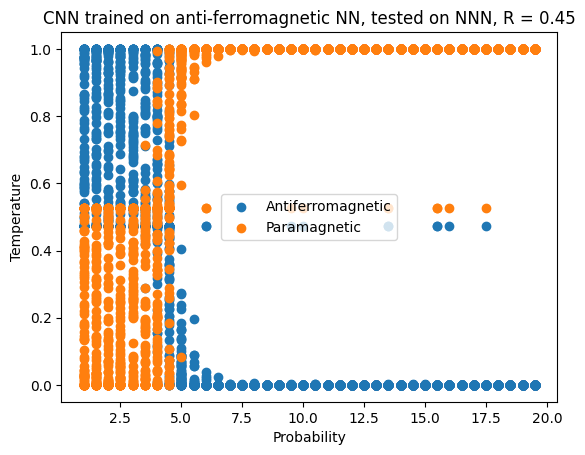

In [95]:
plt.scatter(Y5, pred_class1, label='Antiferromagnetic')
plt.scatter(Y5, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('CNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

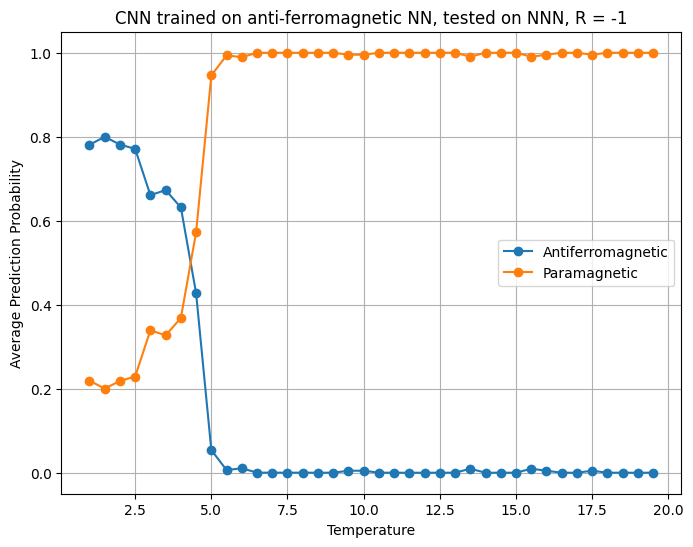

In [97]:
plot_proba(np.array(Y5), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

In [99]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y5)

0.8747368421052631

###### FCNN

In [100]:
dataset5.__len__()

3800

In [101]:
test(FCNN, criterion_FCNN, dataloader5)

0 :: Loss: 1.4435510635375977 ,Test accuracy: 0.48828125
1 :: Loss: 1.3974255323410034 ,Test accuracy: 0.48828125
2 :: Loss: 1.9080017805099487 ,Test accuracy: 0.5078125
3 :: Loss: 2.109886407852173 ,Test accuracy: 0.328125
4 :: Loss: 2.115610122680664 ,Test accuracy: 0.37890625
5 :: Loss: 2.5206966400146484 ,Test accuracy: 0.328125
6 :: Loss: 3.023200273513794 ,Test accuracy: 0.25390625
7 :: Loss: 2.525359630584717 ,Test accuracy: 0.36328125
8 :: Loss: 0.9069781303405762 ,Test accuracy: 0.73046875
9 :: Loss: 0.5225294828414917 ,Test accuracy: 0.81640625
10 :: Loss: 0.911381185054779 ,Test accuracy: 0.75
11 :: Loss: 0.9300879240036011 ,Test accuracy: 0.6953125
12 :: Loss: 0.7517043948173523 ,Test accuracy: 0.77734375
13 :: Loss: 0.5752060413360596 ,Test accuracy: 0.80078125
14 :: Loss: 0.7777203917503357 ,Test accuracy: 0.7734375
15 :: Loss: 0.5083216428756714 ,Test accuracy: 0.83984375
16 :: Loss: 0.5514768362045288 ,Test accuracy: 0.8203125
17 :: Loss: 1.1200940608978271 ,Test accura

In [102]:
pred_class1, pred_class2 = get_predictions(dataloader5, FCNN)

Text(0.5, 1.0, 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

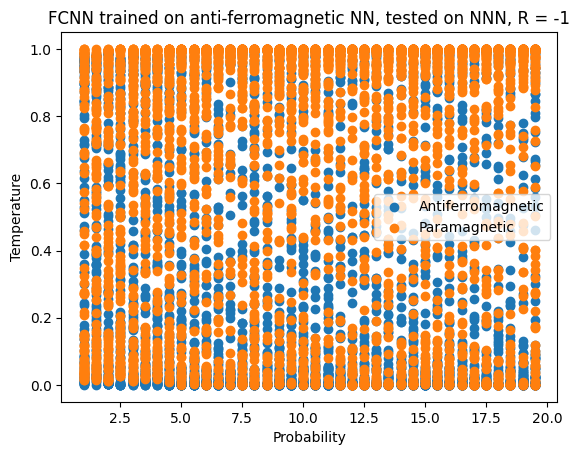

In [103]:
plt.scatter(Y5, pred_class1, label='Antiferromagnetic')
plt.scatter(Y5, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('FCNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

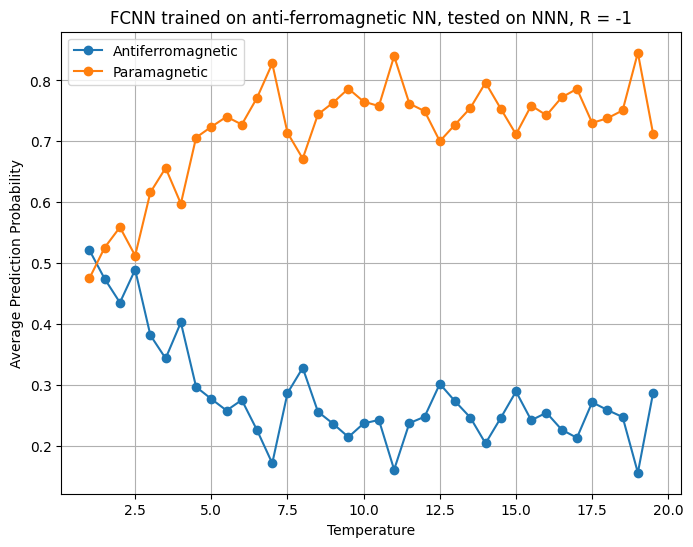

In [104]:
plot_proba(np.array(Y5), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

In [105]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y5)

0.6672368421052631

### Test on R = 0.45 data, train on anti-ferro NN

###### Loading the datasets and the trained model

In [130]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X6, y6, Y6 = full_file_loader('data_64NNN_anti_noshuffle_R045_2.npz', 0.8)

In [131]:
unique_temperatures, indices = np.unique(Y6, return_inverse=True)
unique_temperatures

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9])

In [25]:
y6[300]

array([1., 0.], dtype=float32)

In [26]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset6 = IsingDataset(X6, y6)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader6 = DataLoader(dataset = dataset6, batch_size = batch_size, shuffle = False)

<ipython-input-11-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-11-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [27]:
dataset6.__len__()

2500

In [28]:
test(CNN, criterion_CNN, dataloader6)

0 :: Loss: 8.237300789915025e-05 ,Test accuracy: 1.0
1 :: Loss: 8.474862261209637e-05 ,Test accuracy: 1.0
2 :: Loss: 0.000290063617285341 ,Test accuracy: 1.0
3 :: Loss: 3.826693534851074 ,Test accuracy: 0.8359375
4 :: Loss: 0.008839930407702923 ,Test accuracy: 0.9921875
5 :: Loss: 0.005224481225013733 ,Test accuracy: 1.0
6 :: Loss: 0.00010091299918713048 ,Test accuracy: 1.0
7 :: Loss: 0.005051694344729185 ,Test accuracy: 1.0
8 :: Loss: 3.9817292417865247e-05 ,Test accuracy: 1.0
9 :: Loss: 1.8011800420936197e-05 ,Test accuracy: 1.0
10 :: Loss: 7.712633305345662e-06 ,Test accuracy: 1.0
11 :: Loss: 0.005066854879260063 ,Test accuracy: 1.0
12 :: Loss: 9.44170187722193e-06 ,Test accuracy: 1.0
13 :: Loss: 0.005045880097895861 ,Test accuracy: 1.0
14 :: Loss: 0.01005184929817915 ,Test accuracy: 1.0
15 :: Loss: 3.2243100577034056e-05 ,Test accuracy: 1.0
16 :: Loss: 2.1755236957687885e-05 ,Test accuracy: 1.0
17 :: Loss: 2.5297735191998072e-05 ,Test accuracy: 1.0
18 :: Loss: 0.005042781587690115 

In [29]:
pred_class1, pred_class2 = get_predictions(dataloader6, CNN)

Text(0.5, 1.0, 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

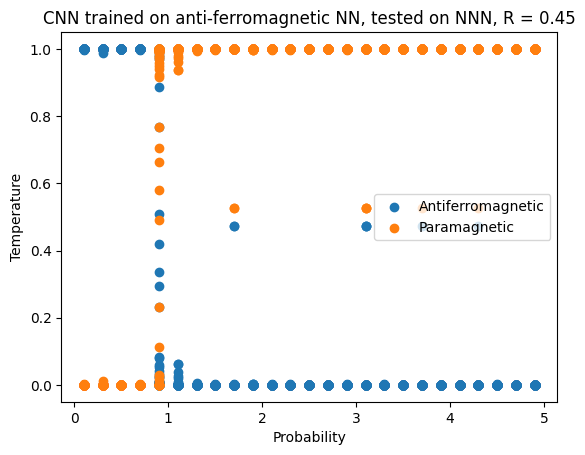

In [30]:
plt.scatter(Y6, pred_class1, label='Antiferromagnetic')
plt.scatter(Y6, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

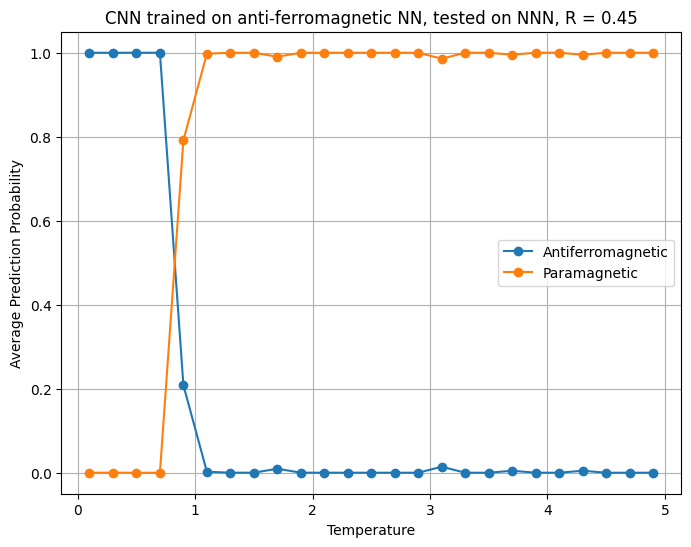

In [42]:
plot_proba(np.array(Y6), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

In [40]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y6)

0.992

###### FCNN

In [43]:
dataset6.__len__()

2500

In [44]:
test(FCNN, criterion_CNN, dataloader6)

0 :: Loss: 0.01296803168952465 ,Test accuracy: 1.0
1 :: Loss: 0.012968456372618675 ,Test accuracy: 1.0
2 :: Loss: 0.013260932639241219 ,Test accuracy: 1.0
3 :: Loss: 1.496140718460083 ,Test accuracy: 0.52734375
4 :: Loss: 0.7739537954330444 ,Test accuracy: 0.71484375
5 :: Loss: 0.5792982578277588 ,Test accuracy: 0.8125
6 :: Loss: 0.6832980513572693 ,Test accuracy: 0.78125
7 :: Loss: 0.6851352453231812 ,Test accuracy: 0.8125
8 :: Loss: 0.8313055634498596 ,Test accuracy: 0.80078125
9 :: Loss: 0.5993313789367676 ,Test accuracy: 0.85546875
10 :: Loss: 0.7513294816017151 ,Test accuracy: 0.7890625
11 :: Loss: 0.6202961206436157 ,Test accuracy: 0.76171875
12 :: Loss: 1.0189374685287476 ,Test accuracy: 0.765625
13 :: Loss: 0.60596764087677 ,Test accuracy: 0.82421875
14 :: Loss: 0.7532979846000671 ,Test accuracy: 0.80859375
15 :: Loss: 0.6342427134513855 ,Test accuracy: 0.8359375
16 :: Loss: 0.967365026473999 ,Test accuracy: 0.75
17 :: Loss: 0.7978464365005493 ,Test accuracy: 0.7890625
18 :: Lo

In [45]:
pred_class1, pred_class2 = get_predictions(dataloader6, FCNN)

Text(0.5, 1.0, 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

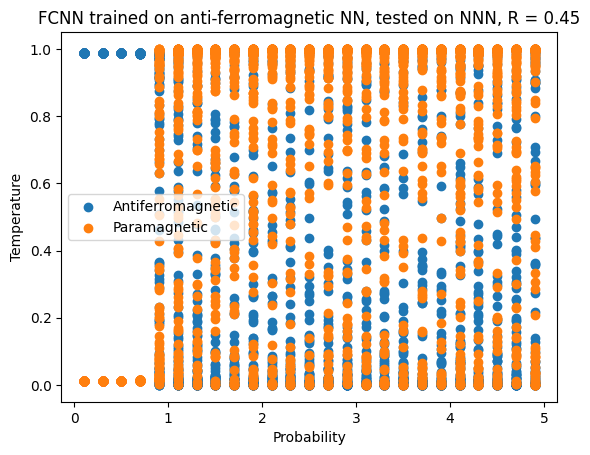

In [46]:
plt.scatter(Y6, pred_class1, label='Antiferromagnetic')
plt.scatter(Y6, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

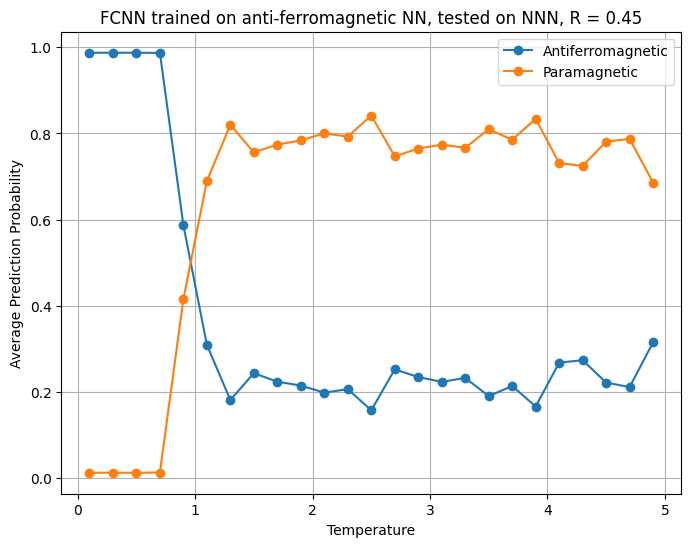

In [47]:
plot_proba(np.array(Y6), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

In [48]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y6)

0.8082

### Test on R = 0.45 data

###### Loading the datasets and the trained model

In [106]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [107]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [108]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X6, y6, Y6 = full_file_loader('data_64NNN_anti_noshuffle_R045.npz', 0.8)

In [109]:
y6[300]

array([1., 0.], dtype=float32)

In [110]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset6 = IsingDataset(X6, y6)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader6 = DataLoader(dataset = dataset6, batch_size = batch_size, shuffle = False)

<ipython-input-11-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-11-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [111]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [112]:
dataset6.__len__()

4900

In [113]:
test(CNN, criterion_CNN, dataloader6)

0 :: Loss: 7.597838878631592 ,Test accuracy: 0.0
1 :: Loss: 6.477779388427734 ,Test accuracy: 0.0
2 :: Loss: 5.033376216888428 ,Test accuracy: 0.0
3 :: Loss: 2.9679417610168457 ,Test accuracy: 0.0390625
4 :: Loss: 5.053009986877441 ,Test accuracy: 0.0390625
5 :: Loss: 8.451223373413086 ,Test accuracy: 0.0
6 :: Loss: 2.515766143798828 ,Test accuracy: 0.75
7 :: Loss: 0.005781108513474464 ,Test accuracy: 1.0
8 :: Loss: 0.0107048861682415 ,Test accuracy: 1.0
9 :: Loss: 0.005089374724775553 ,Test accuracy: 1.0
10 :: Loss: 7.184062269516289e-05 ,Test accuracy: 1.0
11 :: Loss: 0.0001281463191844523 ,Test accuracy: 1.0
12 :: Loss: 0.00019568488642107695 ,Test accuracy: 1.0
13 :: Loss: 2.900106665038038e-05 ,Test accuracy: 1.0
14 :: Loss: 0.00010725780157372355 ,Test accuracy: 1.0
15 :: Loss: 0.01008042972534895 ,Test accuracy: 1.0
16 :: Loss: 1.738034188747406e-05 ,Test accuracy: 1.0
17 :: Loss: 0.005081293638795614 ,Test accuracy: 1.0
18 :: Loss: 0.010093944147229195 ,Test accuracy: 1.0
19 ::

In [114]:
pred_class1, pred_class2 = get_predictions(dataloader6, CNN)

Text(0.5, 1.0, 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

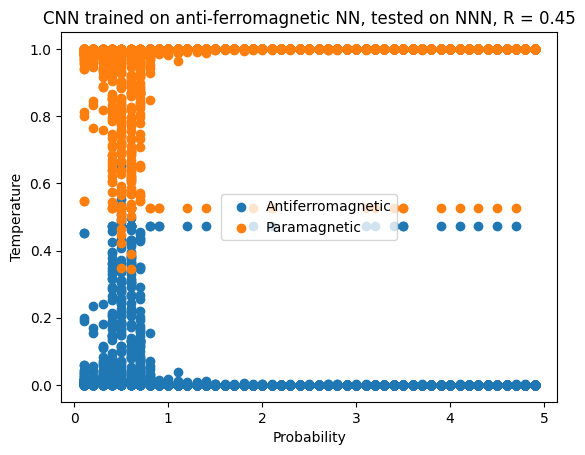

In [115]:
plt.scatter(Y6, pred_class1, label='Antiferromagnetic')
plt.scatter(Y6, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

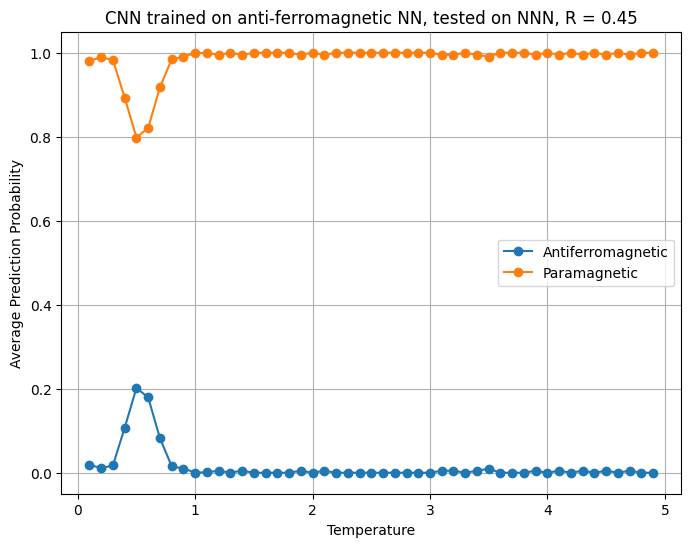

In [116]:
plot_proba(np.array(Y6), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

In [117]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y6)

0.8381632653061224

###### FCNN

In [118]:
dataset6.__len__()

4900

In [119]:
test(FCNN, criterion_CNN, dataloader6)

0 :: Loss: 3.168891191482544 ,Test accuracy: 0.1484375
1 :: Loss: 2.8428595066070557 ,Test accuracy: 0.15625
2 :: Loss: 2.4869794845581055 ,Test accuracy: 0.375
3 :: Loss: 3.0430214405059814 ,Test accuracy: 0.15625
4 :: Loss: 4.041322231292725 ,Test accuracy: 0.08984375
5 :: Loss: 3.3931620121002197 ,Test accuracy: 0.18359375
6 :: Loss: 1.454918622970581 ,Test accuracy: 0.65625
7 :: Loss: 0.4398561418056488 ,Test accuracy: 0.828125
8 :: Loss: 0.5310423970222473 ,Test accuracy: 0.84765625
9 :: Loss: 0.4133118987083435 ,Test accuracy: 0.8828125
10 :: Loss: 0.5927002429962158 ,Test accuracy: 0.7890625
11 :: Loss: 0.5017971992492676 ,Test accuracy: 0.78515625
12 :: Loss: 0.5613054037094116 ,Test accuracy: 0.8359375
13 :: Loss: 0.5803146362304688 ,Test accuracy: 0.796875
14 :: Loss: 0.6726223230361938 ,Test accuracy: 0.828125
15 :: Loss: 0.6241342425346375 ,Test accuracy: 0.828125
16 :: Loss: 0.5699445605278015 ,Test accuracy: 0.76953125
17 :: Loss: 0.5905405879020691 ,Test accuracy: 0.7734

In [120]:
pred_class1, pred_class2 = get_predictions(dataloader6, FCNN)

Text(0.5, 1.0, 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

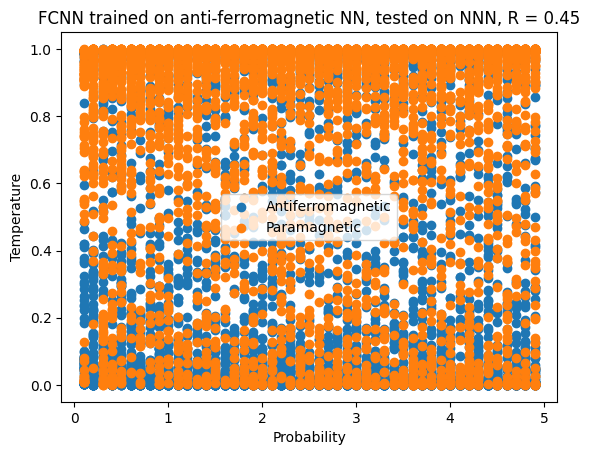

In [121]:
plt.scatter(Y6, pred_class1, label='Antiferromagnetic')
plt.scatter(Y6, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

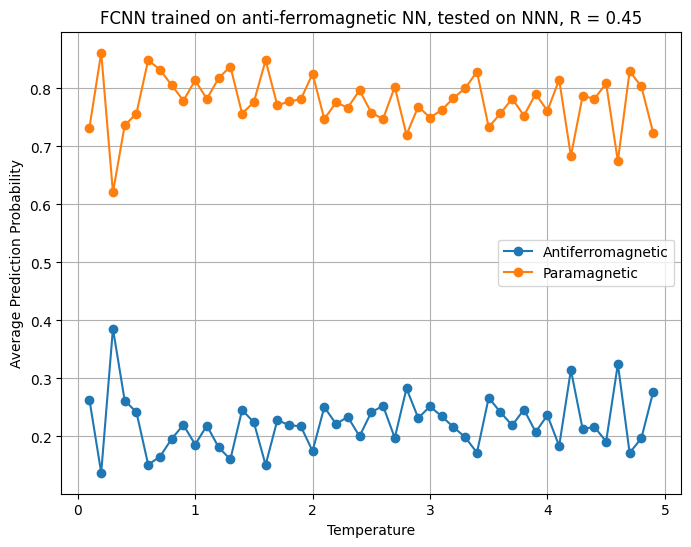

In [122]:
plot_proba(np.array(Y6), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 0.45')

In [123]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y6)

0.6954081632653061

### Test on R = 0.2 data

###### Loading the datasets and the trained model

In [ ]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [ ]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [ ]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X7, y7, Y7 = full_file_loader('data_64NNN_anti_noshuffle_R020.npz', 1.8)

In [ ]:
y7[300]

array([1., 0.], dtype=float32)

In [ ]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset7 = IsingDataset(X7, y7)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader7 = DataLoader(dataset = dataset7, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [ ]:
dataset7.__len__()

4900

In [ ]:
test(CNN, criterion_CNN, dataloader7)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 13.548540115356445 ,Test accuracy: 0.0
1 :: Loss: 4.836541652679443 ,Test accuracy: 0.0
2 :: Loss: 1.7190818786621094 ,Test accuracy: 0.0625
3 :: Loss: 1.192328691482544 ,Test accuracy: 0.2265625
4 :: Loss: 0.8450732231140137 ,Test accuracy: 0.2109375
5 :: Loss: 0.8802001476287842 ,Test accuracy: 0.3359375
6 :: Loss: 0.9159015417098999 ,Test accuracy: 0.234375
7 :: Loss: 0.8909107446670532 ,Test accuracy: 0.375
8 :: Loss: 1.28093421459198 ,Test accuracy: 0.3515625
9 :: Loss: 1.5124404430389404 ,Test accuracy: 0.2734375
10 :: Loss: 2.643387794494629 ,Test accuracy: 0.1328125
11 :: Loss: 4.369933605194092 ,Test accuracy: 0.015625
12 :: Loss: 9.623226165771484 ,Test accuracy: 0.015625
13 :: Loss: 3.8379409313201904 ,Test accuracy: 0.71875
14 :: Loss: 0.000850972137413919 ,Test accuracy: 1.0
15 :: Loss: 0.00010804289195220917 ,Test accuracy: 1.0
16 :: Loss: 0.001031205290928483 ,Test accuracy: 1.0
17 :: Loss: 0.00010509907588129863 ,Test accuracy: 1.0
18 :: Loss: 0.0055325576104

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader7, CNN)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


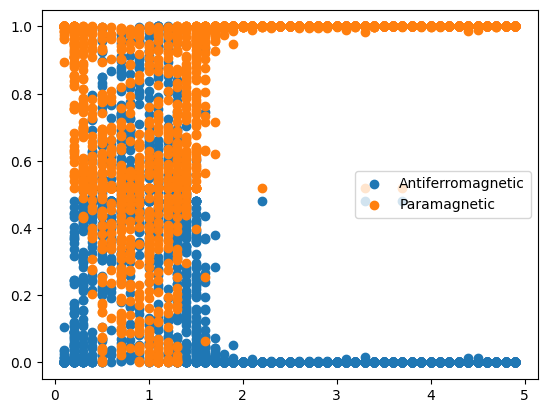

In [ ]:
plt.scatter(Y7, pred_class1, label='Antiferromagnetic')
plt.scatter(Y7, pred_class2, label='Paramagnetic')
plt.legend()

### Test on R = 0.0 data

###### Loading the datasets and the trained model

In [ ]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [ ]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [ ]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X8, y8, Y8 = full_file_loader('data_64NNN_anti_noshuffle_R000.npz', 2.27)

In [ ]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset8 = IsingDataset(X8, y8)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader8 = DataLoader(dataset = dataset8, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [ ]:
dataset8.__len__()

2500

In [ ]:
test(CNN, criterion_CNN, dataloader8)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 0.5319428443908691 ,Test accuracy: 0.515625
1 :: Loss: 0.5719627737998962 ,Test accuracy: 0.390625
2 :: Loss: 0.6074711084365845 ,Test accuracy: 0.359375
3 :: Loss: 0.4496583342552185 ,Test accuracy: 0.6328125
4 :: Loss: 0.6497342586517334 ,Test accuracy: 0.390625
5 :: Loss: 0.718295156955719 ,Test accuracy: 0.3671875
6 :: Loss: 0.9166008234024048 ,Test accuracy: 0.1953125
7 :: Loss: 1.8095805644989014 ,Test accuracy: 0.2421875
8 :: Loss: 1.7068898677825928 ,Test accuracy: 0.4921875
9 :: Loss: 0.008019612170755863 ,Test accuracy: 1.0
10 :: Loss: 0.00024106814817059785 ,Test accuracy: 1.0
11 :: Loss: 2.1415407900349237e-05 ,Test accuracy: 1.0
12 :: Loss: 3.1162851428234717e-06 ,Test accuracy: 1.0
13 :: Loss: 7.869389833103924e-07 ,Test accuracy: 1.0
14 :: Loss: 4.471289230423281e-06 ,Test accuracy: 1.0
15 :: Loss: 0.010277439840137959 ,Test accuracy: 1.0
16 :: Loss: 0.00010203288547927514 ,Test accuracy: 1.0
17 :: Loss: 1.8517539501772262e-05 ,Test accuracy: 1.0
18 :: Loss: 1

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader8, CNN)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


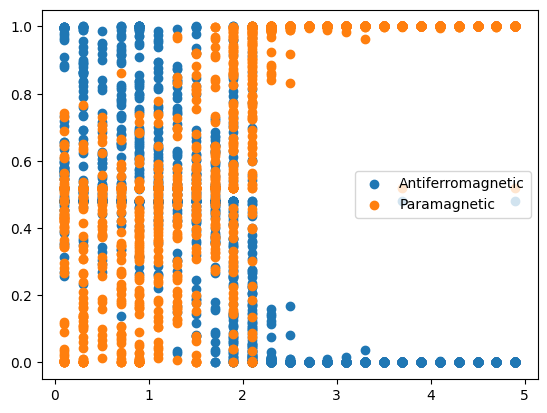

In [ ]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()

Text(0.5, 1.0, 'T=0.1, Class=[1. 0.], Predicted = (0.46454683, 0.5354532)')

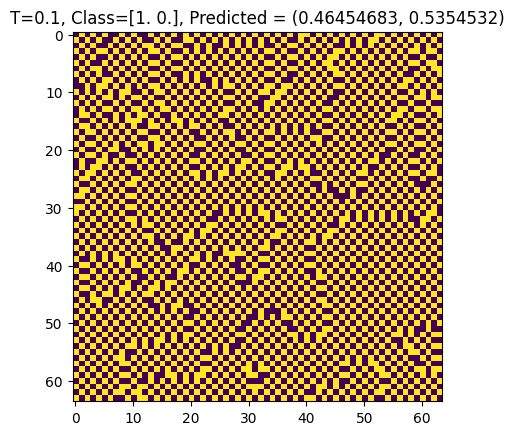

In [ ]:
plt.imshow(X8[80])
plt.title(f"T={Y8[80]}, Class={y8[10]}, Predicted = {pred_class1[80], pred_class2[80]}")

### Test on the second R = 0.0 data

###### Loading the datasets and the trained model

In [ ]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [ ]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [ ]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X8, y8, Y8 = full_file_loader('data_64NNN_anti_noshuffle_R000_2.npz', 2.27)

In [ ]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset8 = IsingDataset(X8, y8)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader8 = DataLoader(dataset = dataset8, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [ ]:
dataset8.__len__()

2500

In [ ]:
test(CNN, criterion_CNN, dataloader8)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 0.005718215834349394 ,Test accuracy: 0.9921875
1 :: Loss: 6.567123818967957e-06 ,Test accuracy: 1.0
2 :: Loss: 0.0003547877713572234 ,Test accuracy: 1.0
3 :: Loss: 4.259426350472495e-05 ,Test accuracy: 1.0
4 :: Loss: 0.005752416793256998 ,Test accuracy: 0.9921875
5 :: Loss: 0.00588105246424675 ,Test accuracy: 0.9921875
6 :: Loss: 0.00017406819097232074 ,Test accuracy: 1.0
7 :: Loss: 0.006245928350836039 ,Test accuracy: 0.9921875
8 :: Loss: 6.984076499938965 ,Test accuracy: 0.609375
9 :: Loss: 7.919984817504883 ,Test accuracy: 0.578125
10 :: Loss: 0.19329464435577393 ,Test accuracy: 0.9609375
11 :: Loss: 0.0005538949044421315 ,Test accuracy: 1.0
12 :: Loss: 9.458595741307363e-05 ,Test accuracy: 1.0
13 :: Loss: 4.0045292735158e-06 ,Test accuracy: 1.0
14 :: Loss: 3.7195502500253497e-07 ,Test accuracy: 1.0
15 :: Loss: 0.00013653244241140783 ,Test accuracy: 1.0
16 :: Loss: 0.00012447415792848915 ,Test accuracy: 1.0
17 :: Loss: 5.469104144140147e-05 ,Test accuracy: 1.0
18 :: Loss:

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader8, CNN)

<ipython-input-15-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


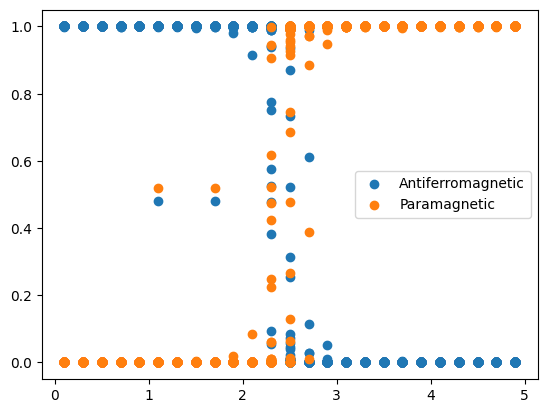

In [ ]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()

Text(0.5, 1.0, 'T=0.1, Class=[1. 0.], Predicted = (1.0, 1.3216908e-22)')

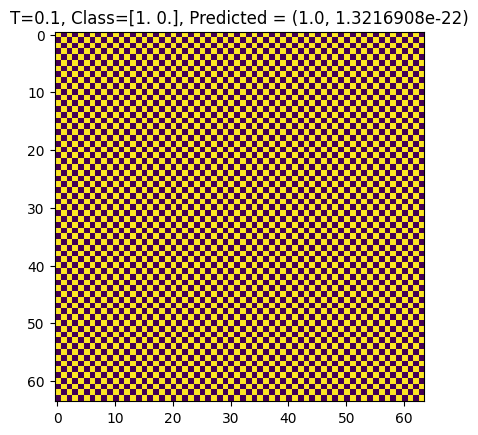

In [ ]:
plt.imshow(X8[80])
plt.title(f"T={Y8[80]}, Class={y8[10]}, Predicted = {pred_class1[80], pred_class2[80]}")

###### FCNN

In [ ]:
dataset8.__len__()

2500

In [ ]:
test(FCNN, criterion_FCNN, dataloader8)

0 :: Loss: 0.013960292562842369 ,Test accuracy: 1.0
1 :: Loss: 0.013960307464003563 ,Test accuracy: 1.0
2 :: Loss: 0.01396034937351942 ,Test accuracy: 1.0
3 :: Loss: 0.013960465788841248 ,Test accuracy: 1.0
4 :: Loss: 0.013965154998004436 ,Test accuracy: 1.0
5 :: Loss: 0.01397240161895752 ,Test accuracy: 1.0
6 :: Loss: 0.0140043580904603 ,Test accuracy: 1.0
7 :: Loss: 0.014136604964733124 ,Test accuracy: 1.0
8 :: Loss: 1.6827988624572754 ,Test accuracy: 0.59375
9 :: Loss: 2.9467172622680664 ,Test accuracy: 0.15234375
10 :: Loss: 1.4144538640975952 ,Test accuracy: 0.5703125
11 :: Loss: 0.7186568975448608 ,Test accuracy: 0.76953125
12 :: Loss: 0.7482439875602722 ,Test accuracy: 0.7578125
13 :: Loss: 0.7041882276535034 ,Test accuracy: 0.8046875
14 :: Loss: 0.6039082407951355 ,Test accuracy: 0.78515625
15 :: Loss: 0.6035948991775513 ,Test accuracy: 0.8359375
16 :: Loss: 0.7782471179962158 ,Test accuracy: 0.7578125
17 :: Loss: 0.6846439242362976 ,Test accuracy: 0.78125
18 :: Loss: 1.0917007

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader8, FCNN)

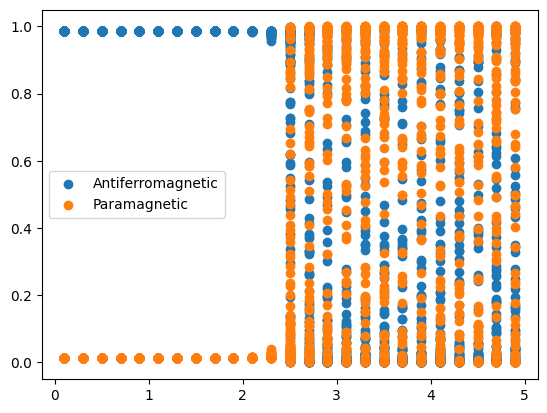

In [ ]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()

### Test on the second R = -1 data, train on anti-ferro NN

###### Loading the datasets and the trained model

In [124]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X8, y8, Y8 = full_file_loader('data_64NNN_anti_noshuffle_R1_2.npz', 5.5)

In [126]:
unique_temperatures, indices = np.unique(Y8, return_inverse=True)
unique_temperatures

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. , 8.5, 9. , 9.5])

In [50]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset8 = IsingDataset(X8, y8)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader8 = DataLoader(dataset = dataset8, batch_size = batch_size, shuffle = False)

<ipython-input-11-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-11-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [51]:
dataset8.__len__()

1900

In [52]:
test(CNN, criterion_CNN, dataloader8)

0 :: Loss: 1.6514843082404695e-05 ,Test accuracy: 1.0
1 :: Loss: 0.00010332205420127138 ,Test accuracy: 1.0
2 :: Loss: 8.261515176855028e-05 ,Test accuracy: 1.0
3 :: Loss: 0.006152384914457798 ,Test accuracy: 0.9921875
4 :: Loss: 4.799186353920959e-05 ,Test accuracy: 1.0
5 :: Loss: 0.00017679111624602228 ,Test accuracy: 1.0
6 :: Loss: 0.00011366457329131663 ,Test accuracy: 1.0
7 :: Loss: 0.4618661403656006 ,Test accuracy: 0.90625
8 :: Loss: 3.368964672088623 ,Test accuracy: 0.5546875
9 :: Loss: 0.000571718905121088 ,Test accuracy: 1.0
10 :: Loss: 0.00555919436737895 ,Test accuracy: 1.0
11 :: Loss: 0.0002230409299954772 ,Test accuracy: 1.0
12 :: Loss: 0.0050320555455982685 ,Test accuracy: 1.0
13 :: Loss: 8.390088623855263e-05 ,Test accuracy: 1.0
14 :: Loss: 4.7487879783147946e-05 ,Test accuracy: 1.0


In [64]:
pred_class1, pred_class2 = get_predictions(dataloader8, CNN)

Text(0.5, 1.0, 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

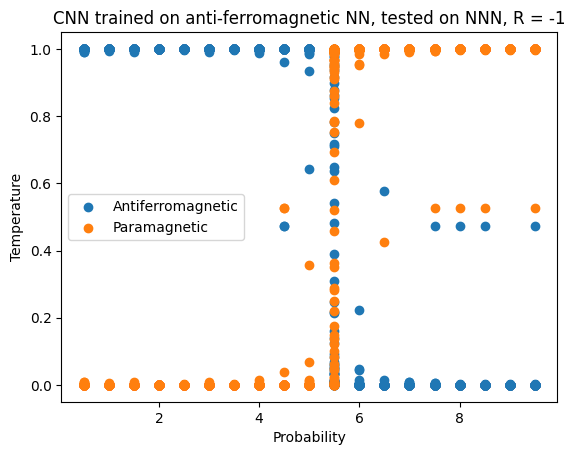

In [54]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('CNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

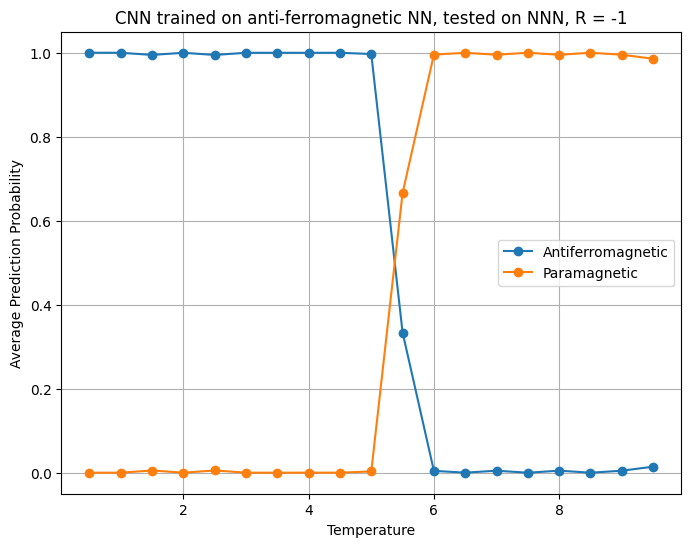

In [65]:
plot_proba(np.array(Y8), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

In [56]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y8)

0.9615789473684211

###### FCNN

In [57]:
dataset8.__len__()

1900

In [58]:
test(FCNN, criterion_FCNN, dataloader8)

0 :: Loss: 0.01296803168952465 ,Test accuracy: 1.0
1 :: Loss: 0.012968078255653381 ,Test accuracy: 1.0
2 :: Loss: 0.012969395145773888 ,Test accuracy: 1.0
3 :: Loss: 0.012976203113794327 ,Test accuracy: 1.0
4 :: Loss: 0.01300485897809267 ,Test accuracy: 1.0
5 :: Loss: 0.013053861446678638 ,Test accuracy: 1.0
6 :: Loss: 0.01325194537639618 ,Test accuracy: 1.0
7 :: Loss: 0.019891006872057915 ,Test accuracy: 1.0
8 :: Loss: 0.6395037174224854 ,Test accuracy: 0.7734375
9 :: Loss: 0.8189873099327087 ,Test accuracy: 0.68359375
10 :: Loss: 0.9232242107391357 ,Test accuracy: 0.75
11 :: Loss: 0.79638671875 ,Test accuracy: 0.765625
12 :: Loss: 0.5959843397140503 ,Test accuracy: 0.8203125
13 :: Loss: 0.7480328679084778 ,Test accuracy: 0.765625
14 :: Loss: 0.4304143786430359 ,Test accuracy: 0.8518518518518519


In [59]:
pred_class1, pred_class2 = get_predictions(dataloader8, FCNN)

Text(0.5, 1.0, 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

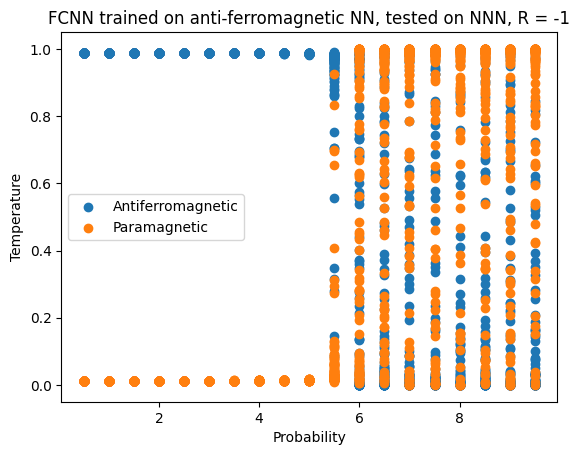

In [60]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('FCNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

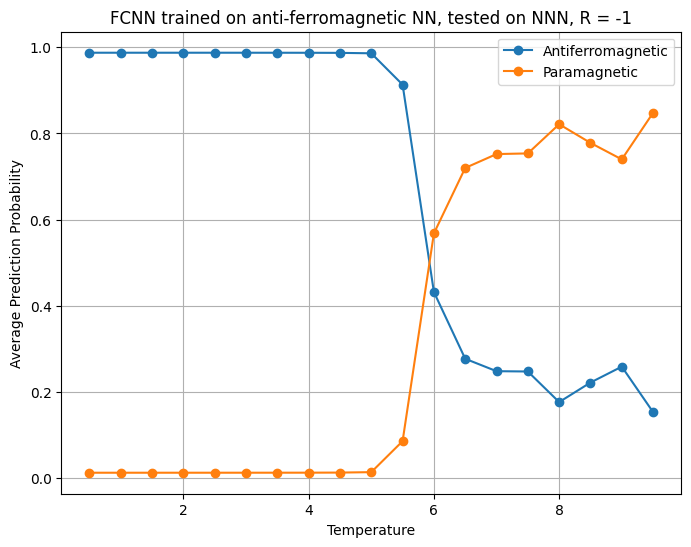

In [62]:
plot_proba(np.array(Y8), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = -1')

In [63]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y8)

0.8944736842105263

###### Visualization

Text(0.5, 1.0, 'T=0.5, Class=[1. 0.], Predicted = (1.0, 2.8527477e-15)')

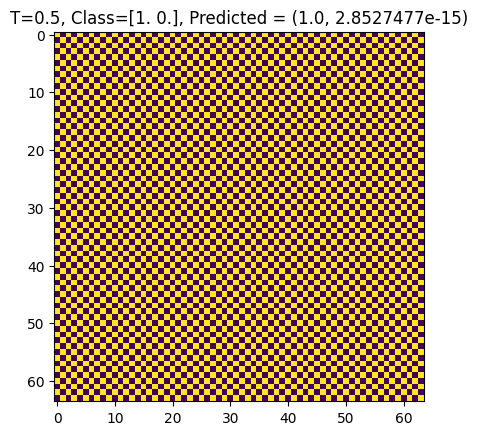

In [ ]:
plt.imshow(X8[80])
plt.title(f"T={Y8[80]}, Class={y8[10]}, Predicted = {pred_class1[80], pred_class2[80]}")

### Test on the second R = +2 data, trained on anti-ferro NN

###### Loading the datasets and the trained model

In [128]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X8, y8, Y8 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [129]:
unique_temperatures, indices = np.unique(Y8, return_inverse=True)
unique_temperatures

array([2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ])

In [70]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset8 = IsingDataset(X8, y8)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader8 = DataLoader(dataset = dataset8, batch_size = batch_size, shuffle = False)

<ipython-input-11-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-11-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [71]:
# CNN.load_state_dict(torch.load('CNN_anti.pth', map_location=torch.device('cpu')))

###### CNN

In [72]:
dataset8.__len__()

1200

In [73]:
test(CNN, criterion_CNN, dataloader8)

0 :: Loss: 76.01826477050781 ,Test accuracy: 0.0
1 :: Loss: 78.15718841552734 ,Test accuracy: 0.0
2 :: Loss: 75.52207946777344 ,Test accuracy: 0.0
3 :: Loss: 66.64347839355469 ,Test accuracy: 0.09375
4 :: Loss: 8.835412472762982e-07 ,Test accuracy: 1.0
5 :: Loss: 8.970093858806649e-07 ,Test accuracy: 1.0
6 :: Loss: 0.005023800767958164 ,Test accuracy: 1.0
7 :: Loss: 0.015070992521941662 ,Test accuracy: 1.0
8 :: Loss: 0.005023568868637085 ,Test accuracy: 1.0
9 :: Loss: 2.990449274875573e-06 ,Test accuracy: 1.0


In [74]:
pred_class1, pred_class2 = get_predictions(dataloader8, CNN)

Text(0.5, 1.0, 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 2')

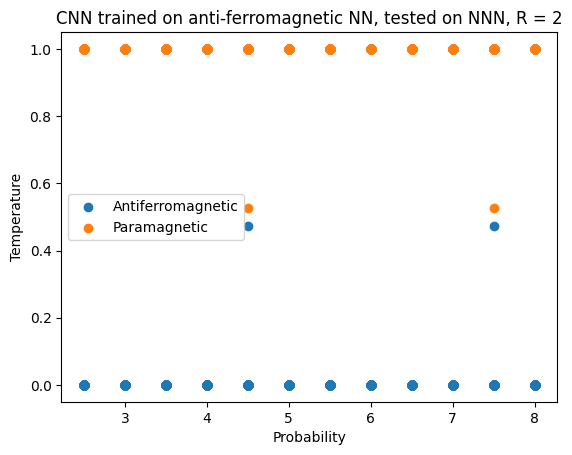

In [76]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('CNN trained on anti-ferromagnetic NN, tested on NNN, R = 2')

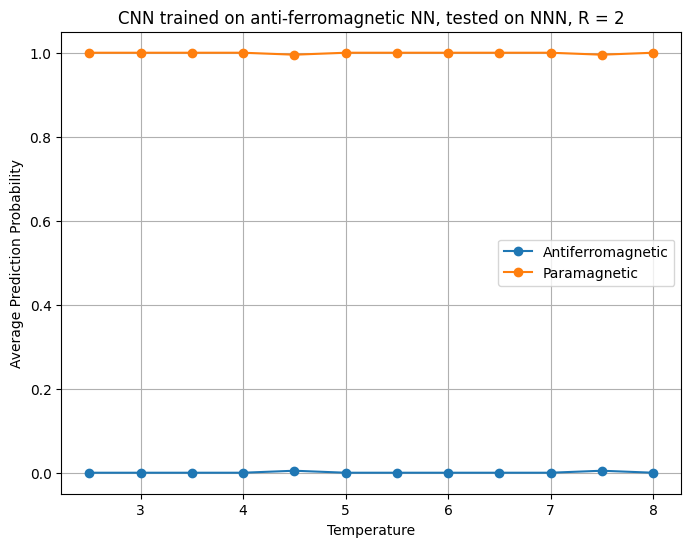

In [81]:
plot_proba(np.array(Y8), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'CNN trained on anti-ferromagnetic NN, tested on NNN, R = 2')

In [78]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y8)

0.5833333333333334

###### FCNN

In [79]:
dataset8.__len__()

1200

In [80]:
test(FCNN, criterion_FCNN, dataloader8)

0 :: Loss: 1.3826231956481934 ,Test accuracy: 0.0703125
1 :: Loss: 1.6033718585968018 ,Test accuracy: 0.1484375
2 :: Loss: 1.821531057357788 ,Test accuracy: 0.25
3 :: Loss: 3.54740047454834 ,Test accuracy: 0.2578125
4 :: Loss: 0.9356042146682739 ,Test accuracy: 0.7734375
5 :: Loss: 0.8071781992912292 ,Test accuracy: 0.796875
6 :: Loss: 1.180803656578064 ,Test accuracy: 0.74609375
7 :: Loss: 1.003239393234253 ,Test accuracy: 0.7421875
8 :: Loss: 1.0100048780441284 ,Test accuracy: 0.72265625
9 :: Loss: 0.6380962133407593 ,Test accuracy: 0.7916666666666666


In [82]:
pred_class1, pred_class2 = get_predictions(dataloader8, FCNN)

Text(0.5, 1.0, 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 2')

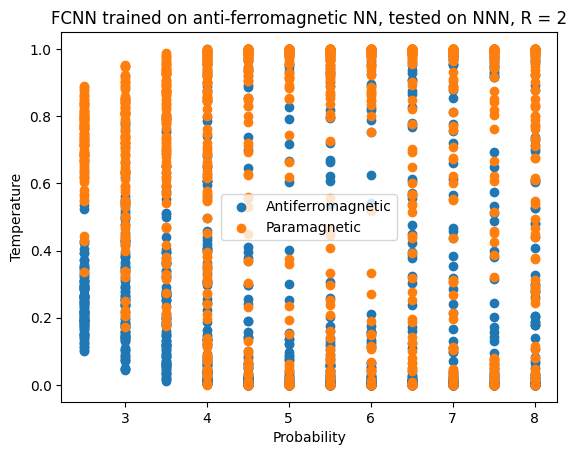

In [83]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Temperature')
plt.title('FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 2')

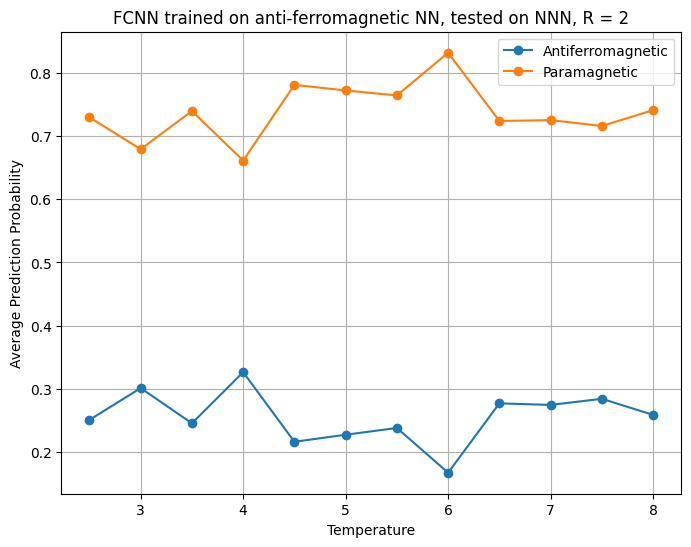

In [86]:
plot_proba(np.array(Y8), np.array(pred_class1), np.array(pred_class2), 'Antiferromagnetic', 'Paramagnetic', 'FCNN trained on anti-ferromagnetic NN, tested on NNN, R = 2')

In [85]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y8)

0.5125

Text(0.5, 1.0, 'Temperature=9.0')

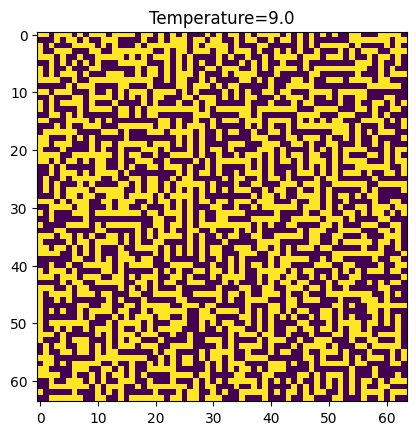

In [ ]:
plt.imshow(X8[1600])
plt.title(f"Temperature={Y8[1600]}")

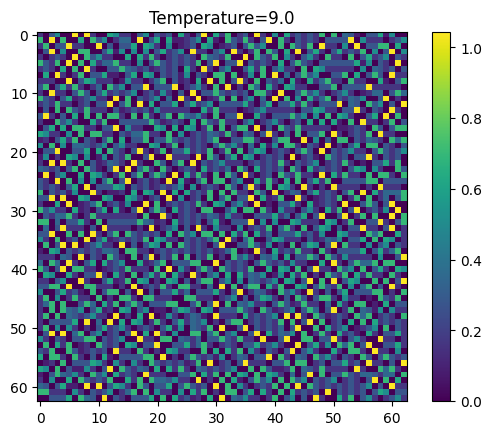

In [ ]:
plot_feature_map(CNN, X8[1600], Y8[1600])

Text(0.5, 1.0, 'Temperature=1.0')

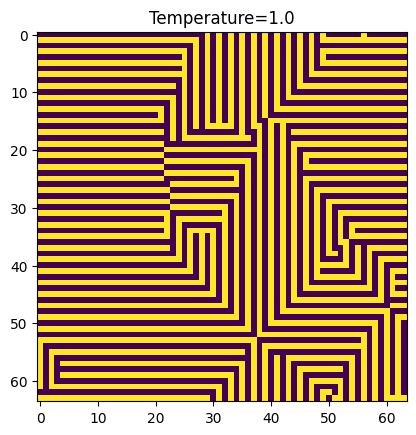

In [ ]:
plt.imshow(X8[0])
plt.title(f"Temperature={Y8[0]}")

In [ ]:
  x = X8[8]
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = CNN(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  data

array([[0.2770608, 0.2770608, 0.2770608, ..., 0.2770608, 0.2770608,
        0.2770608],
       [0.1601424, 0.1601424, 0.1601424, ..., 0.1601424, 0.1601424,
        0.1601424],
       [0.2770608, 0.2770608, 0.2770608, ..., 0.2770608, 0.2770608,
        0.2770608],
       ...,
       [0.2770608, 0.2770608, 0.2770608, ..., 0.2770608, 0.2770608,
        0.2770608],
       [0.1601424, 0.1601424, 0.1601424, ..., 0.1601424, 0.1601424,
        0.1601424],
       [0.2770608, 0.2770608, 0.2770608, ..., 0.2770608, 0.2770608,
        0.2770608]], dtype=float32)

[[0.2770608  0.2770608  0.2770608  ... 0.2770608  0.2770608  0.2770608 ]
 [0.1601424  0.1601424  0.1601424  ... 0.1601424  0.1601424  0.1601424 ]
 [0.2770608  0.2770608  0.2770608  ... 0.2770608  0.2770608  0.2770608 ]
 ...
 [0.15775235 0.27945083 0.         ... 0.15775235 0.27945083 0.15775235]
 [0.         0.698336   0.1601424  ... 0.15775235 0.27945083 0.15775235]
 [0.2770608  0.2770608  0.2770608  ... 0.         0.62539035 0.        ]]


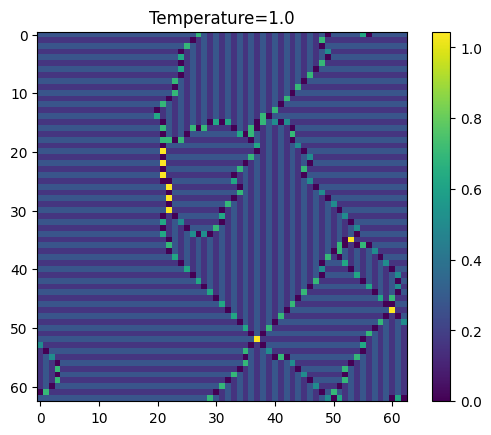

In [ ]:
plot_feature_map(CNN, X8[0], Y8[0], print_data = True)

###### FCNN

In [ ]:
dataset8.__len__()

1900

In [ ]:
test(FCNN, criterion_FCNN, dataloader8)

0 :: Loss: 0.013960292562842369 ,Test accuracy: 1.0
1 :: Loss: 0.01396047044545412 ,Test accuracy: 1.0
2 :: Loss: 0.01396141666918993 ,Test accuracy: 1.0
3 :: Loss: 3.745008707046509 ,Test accuracy: 0.125
4 :: Loss: 4.276422500610352 ,Test accuracy: 0.0
5 :: Loss: 4.274286270141602 ,Test accuracy: 0.0
6 :: Loss: 4.262692451477051 ,Test accuracy: 0.0
7 :: Loss: 4.079700946807861 ,Test accuracy: 0.0
8 :: Loss: 2.350159168243408 ,Test accuracy: 0.23828125
9 :: Loss: 1.0301077365875244 ,Test accuracy: 0.66796875
10 :: Loss: 0.9503437280654907 ,Test accuracy: 0.7578125
11 :: Loss: 0.7263312935829163 ,Test accuracy: 0.7421875
12 :: Loss: 0.6175479888916016 ,Test accuracy: 0.796875
13 :: Loss: 0.7838944792747498 ,Test accuracy: 0.75
14 :: Loss: 0.7488068342208862 ,Test accuracy: 0.8055555555555556


In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader8, FCNN)

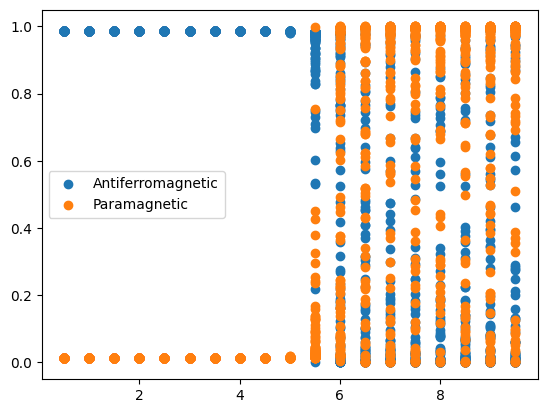

In [ ]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()

###### Visualization

Text(0.5, 1.0, 'T=0.5, Class=[1. 0.], Predicted = (1.0, 2.8527477e-15)')

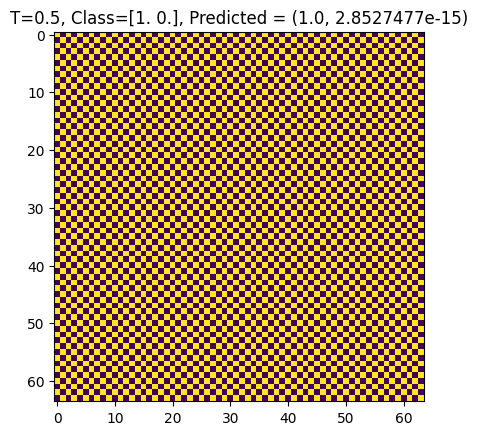

In [ ]:
plt.imshow(X8[80])
plt.title(f"T={Y8[80]}, Class={y8[10]}, Predicted = {pred_class1[80], pred_class2[80]}")

### Transfer Learning

In [ ]:
# Anti-ferromagnetic dataset: train and test

# X_train8, X_test8, y_train8, y_test8, Y_train8, Y_test8 = file_loader('data_64NNN_anti_noshuffle_Rplus2.npz', 4)
X_train8, X_test8, y_train8, y_test8, Y_train8, Y_test8 = file_loader('data.npz')

In [ ]:
training_dataset8 = IsingDataset(X_train8, y_train8)
testing_dataset8 = IsingDataset(X_test8, y_test8)
batch_size = 128
train_dataloader8 = DataLoader(dataset = training_dataset8, batch_size = batch_size, shuffle = False)
test_dataloader8 = DataLoader(dataset = testing_dataset8, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
CNN2 = ConvNet(Nx, Ny)  # or load from saved state
CNN2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam(CNN2.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(CNN2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=train_dataloader8)


Loss: 0.6670994758605957 ,Train accuracy: 0.6015625
Loss: 0.44042956829071045 ,Train accuracy: 0.8125
Loss: 0.2821506857872009 ,Train accuracy: 0.8671875
Loss: 0.32592281699180603 ,Train accuracy: 0.8125
Loss: 0.24306997656822205 ,Train accuracy: 0.8359375
Loss: 0.248711958527565 ,Train accuracy: 0.8515625
Loss: 0.23064076900482178 ,Train accuracy: 0.8671875
Loss: 0.22731533646583557 ,Train accuracy: 0.859375
Loss: 0.2035108208656311 ,Train accuracy: 0.890625
Loss: 0.21004357933998108 ,Train accuracy: 0.8828125


In [ ]:
test(CNN2, criterion, dataloader8)

0 :: Loss: 0.584089994430542 ,Test accuracy: 0.4921875
1 :: Loss: 0.6237149238586426 ,Test accuracy: 0.4765625
2 :: Loss: 1.6295113563537598 ,Test accuracy: 0.21875
3 :: Loss: 1.9088799953460693 ,Test accuracy: 0.1484375
4 :: Loss: 1.9044232368469238 ,Test accuracy: 0.1015625
5 :: Loss: 1.9064795970916748 ,Test accuracy: 0.5546875
6 :: Loss: 0.03851892426609993 ,Test accuracy: 1.0
7 :: Loss: 0.029451223090291023 ,Test accuracy: 1.0
8 :: Loss: 0.02457180619239807 ,Test accuracy: 1.0
9 :: Loss: 0.018058549612760544 ,Test accuracy: 1.0
10 :: Loss: 0.015856828540563583 ,Test accuracy: 1.0
11 :: Loss: 0.014908232726156712 ,Test accuracy: 1.0
12 :: Loss: 0.016898201778531075 ,Test accuracy: 1.0
13 :: Loss: 0.007624872960150242 ,Test accuracy: 1.0
14 :: Loss: 0.008257403038442135 ,Test accuracy: 1.0


In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader8, CNN2)

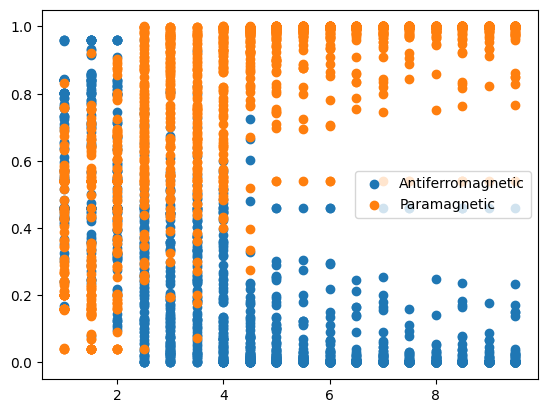

In [ ]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()

[[0.01113349 0.01113349 0.01113349 ... 0.01113349 0.01113349 0.01113349]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01113349 0.01113349 0.01113349 ... 0.01113349 0.01113349 0.01113349]
 ...
 [0.01113349 0.01113349 0.01113349 ... 0.01113349 0.01113349 0.01113349]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01113349 0.01113349 0.01113349 ... 0.01113349 0.01113349 0.01113349]]


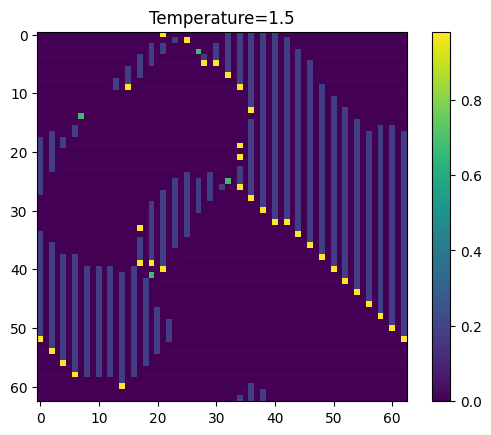

In [ ]:
plot_feature_map(CNN2, X8[100], Y8[100], print_data = True)

###### Transfer learning on ferromagnetic data

In [ ]:
training_dataset8 = IsingDataset(X_train8, y_train8)
testing_dataset8 = IsingDataset(X_test8, y_test8)
batch_size = 128
train_dataloader_shuffle = DataLoader(dataset = training_dataset8, batch_size = batch_size, shuffle = True)
test_dataloader_shuffle = DataLoader(dataset = testing_dataset8, batch_size = batch_size, shuffle = True)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
# Create the new DataLoader containing the first 20 batches of the original DataLoader
num_batches_to_take = 10
new_dataloader = SubsetDataLoader(train_dataloader_shuffle, num_batches_to_take)

# Now you can iterate over new_dataloader to access the first 20 batches of the original DataLoader
for batch_idx, (data, labels) in enumerate(new_dataloader):
    print(f"Batch {batch_idx + 1}: Data shape: {data.shape}, Labels shape: {labels.shape}")

Batch 1: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 2: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 3: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 4: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 5: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 6: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 7: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 8: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 9: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 10: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])


In [ ]:
CNNferro = ConvNet(Nx, Ny)  # or load from saved state
CNNferro.to(device)
# Setup optimizer - only optimize the unfrozen parameters
optimizer_ferro = optim.Adam(CNNferro.parameters(), lr=1e-4, betas=[0.9,0.999])
# Define the loss function
criterion = nn.BCELoss()
# Example usage of the training function with dataloader8
train(CNNferro, num_epochs=3, criterion=criterion, optimizer=optimizer_ferro, train_dataloader=new_dataloader)

Loss: 0.6988416910171509 ,Train accuracy: 0.5234375
Loss: 0.766608476638794 ,Train accuracy: 0.8515625
Loss: 3.834104537963867 ,Train accuracy: 0.828125


In [ ]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, CNNferro)

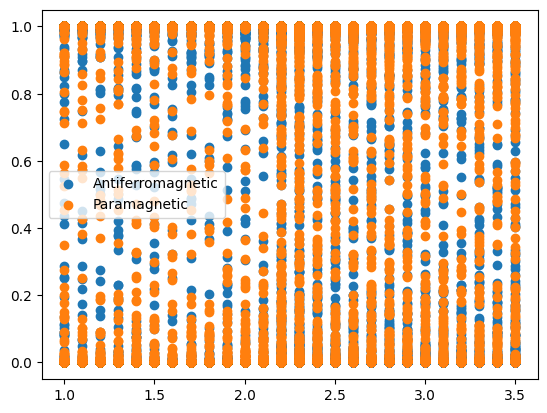

In [ ]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
# model.fc1.weight.data = pretrained_model.fc1.weight.data
# model.fc1.bias.data = pretrained_model.fc1.bias.data
model.fc2.weight.data = pretrained_model.fc2.weight.data
model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
# model.fc2.weight.requires_grad = True
# model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=3, criterion=criterion, optimizer=optimizer, train_dataloader=new_dataloader)


Loss: 0.6777243614196777 ,Train accuracy: 0.578125
Loss: 0.08671995252370834 ,Train accuracy: 0.96875
Loss: 0.05212636664509773 ,Train accuracy: 0.9921875


In [ ]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, model)

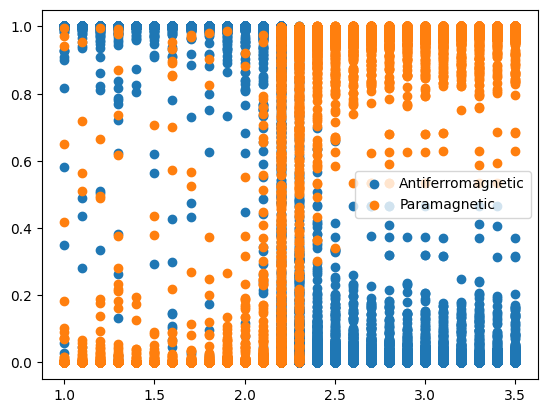

In [ ]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()

###### Training CNN on horizontal and vertical stripes

In [ ]:
import numpy as np

# Function to create a single sample with horizontal stripes
def create_horizontal_stripes(size):
    sample = np.zeros((size, size))
    for i in range(size):
        if i % 2 == 0:
            sample[i, :] = 1
        else:
            sample[i, :] = -1
    return sample

# Function to create a single sample with vertical stripes
def create_vertical_stripes(size):
    sample = np.zeros((size, size))
    for i in range(size):
        if i % 2 == 0:
            sample[:, i] = 1
        else:
            sample[:, i] = -1
    return sample

# Number of samples
num_samples = 20000

# Matrix size
matrix_size = 64

# Create horizontal stripe samples
horizontal_samples = [create_horizontal_stripes(matrix_size) for _ in range(num_samples // 2)]

# Create vertical stripe samples
vertical_samples = [create_vertical_stripes(matrix_size) for _ in range(num_samples // 2)]

# Combine horizontal and vertical samples
samples = horizontal_samples + vertical_samples

# Convert samples to numpy array
dataset = np.array(samples)

# # Reshape the dataset to add a channel dimension (since Conv2D expects input with shape (batch_size, channels, height, width))
# dataset = np.expand_dims(dataset, axis=1)

# Print the shape of the dataset
print("Shape of dataset:", dataset.shape)


Shape of dataset: (20000, 64, 64)


In [ ]:
CNNstripes = ConvNet(64,64)
